In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob

from tqdm.notebook import tqdm

In [56]:
suffixes_1 = ["", "_2"]
suffixes_2 = ["", "_kelex"]
dataframes = {}

for suffix_1 in suffixes_1:
    for suffix_2 in suffixes_2:
        subset_pattern = f"./data/result_*t_vs_*f{suffix_2}_15attempts_bsbbert{suffix_1}.tsv"
        # Get a list of files for the current subset pattern:
        subset_files = glob.glob(subset_pattern)
        subset_dataframes = {}
        for file_path in subset_files:
            # Extract num_true and num_false from the file name:
            num_true, num_false = map(int, (file_path.split('_')[1][0], file_path.split('_')[3][0]))
            
            df = pd.read_csv(file_path, sep='\t', decimal=",", header=0)
            subset_dataframes[(num_true, num_false)] = df
        dataframes[(suffix_1, suffix_2)] = subset_dataframes

In [57]:
dataframes[("", "")][(1, 1)]

,constr,definition,examples,positive_predicted,negative_predicted,true_positives,false_positives,false_negatives,true_negatives,precision,recall,f1,accuracy
0,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Er hatte ein Gesicht wie ein Mehlsack .', 'D...",[],"['Er hatte ein Gesicht wie ein Mehlsack .', 'D...",[],[],"['Da merkt kein Mensch , dass wir alle das gle...",['Er hatte ein Gesicht wie ein Mehlsack .'],1.0,1.0,1.0,0.5
1,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Knutschen , bis der Arzt kommt', 'Noch aber ...","['Knutschen , bis der Arzt kommt']",['Noch aber hat keiner der Bundesstaaten eine ...,[],"['Knutschen , bis der Arzt kommt']",['Noch aber hat keiner der Bundesstaaten eine ...,[],0.0,1.0,0.0,0.0
2,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Keine Spur einer Entrüstung , geschweige den...",[],"['Keine Spur einer Entrüstung , geschweige den...",[],[],"['Keine Spur einer Entrüstung , geschweige den...",['Damit drängt sie diese Frauen raus aus der Ö...,1.0,1.0,1.0,0.5
3,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...",['Andererseits fürchteten sie ein einseitiges ...,[],['Andererseits fürchteten sie ein einseitiges ...,[],[],"['Gewiss , Jimmy bildet sich ein , dass sich d...",['Andererseits fürchteten sie ein einseitiges ...,1.0,1.0,1.0,0.5
4,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Weil Funktionäre , Politiker , Ärzte sowie T...","['Weil Funktionäre , Politiker , Ärzte sowie T...",['Der Gottesdienst fängt erst um sieben nach s...,"['Weil Funktionäre , Politiker , Ärzte sowie T...",[],[],['Der Gottesdienst fängt erst um sieben nach s...,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...","['Edwin ist ruhig , noch ruhiger als sonst .',...",['Heute Abend um 22 Uhr 30 wird auf B 1 zwar n...,"['Edwin ist ruhig , noch ruhiger als sonst .']",[],['Heute Abend um 22 Uhr 30 wird auf B 1 zwar n...,"['Edwin ist ruhig , noch ruhiger als sonst .']",[],0.0,1.0,0.0,0.0
3161,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...","['"" Nur "" kommissarisch "" organisiere sein Tea...","['Wichtiger als die Frage , wer sich aus diese...","['"" Nur "" kommissarisch "" organisiere sein Tea...","['Wichtiger als die Frage , wer sich aus diese...",[],[],"['"" Nur "" kommissarisch "" organisiere sein Tea...",1.0,1.0,1.0,1.0
3162,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...",['»Ohne Europa sind viele Fragen nicht mehr se...,['Damit wäre der Geländewagen deutlich günstig...,['»Ohne Europa sind viele Fragen nicht mehr se...,['Damit wäre der Geländewagen deutlich günstig...,[],[],['»Ohne Europa sind viele Fragen nicht mehr se...,1.0,1.0,1.0,1.0
3163,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...",['Wegen eines Fehlers wird er durch einen Schr...,[],['Wegen eines Fehlers wird er durch einen Schr...,[],[],['Rund 45 . 000 Dollar soll der Byton - SUV ko...,['Wegen eines Fehlers wird er durch einen Schr...,1.0,1.0,1.0,0.5


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

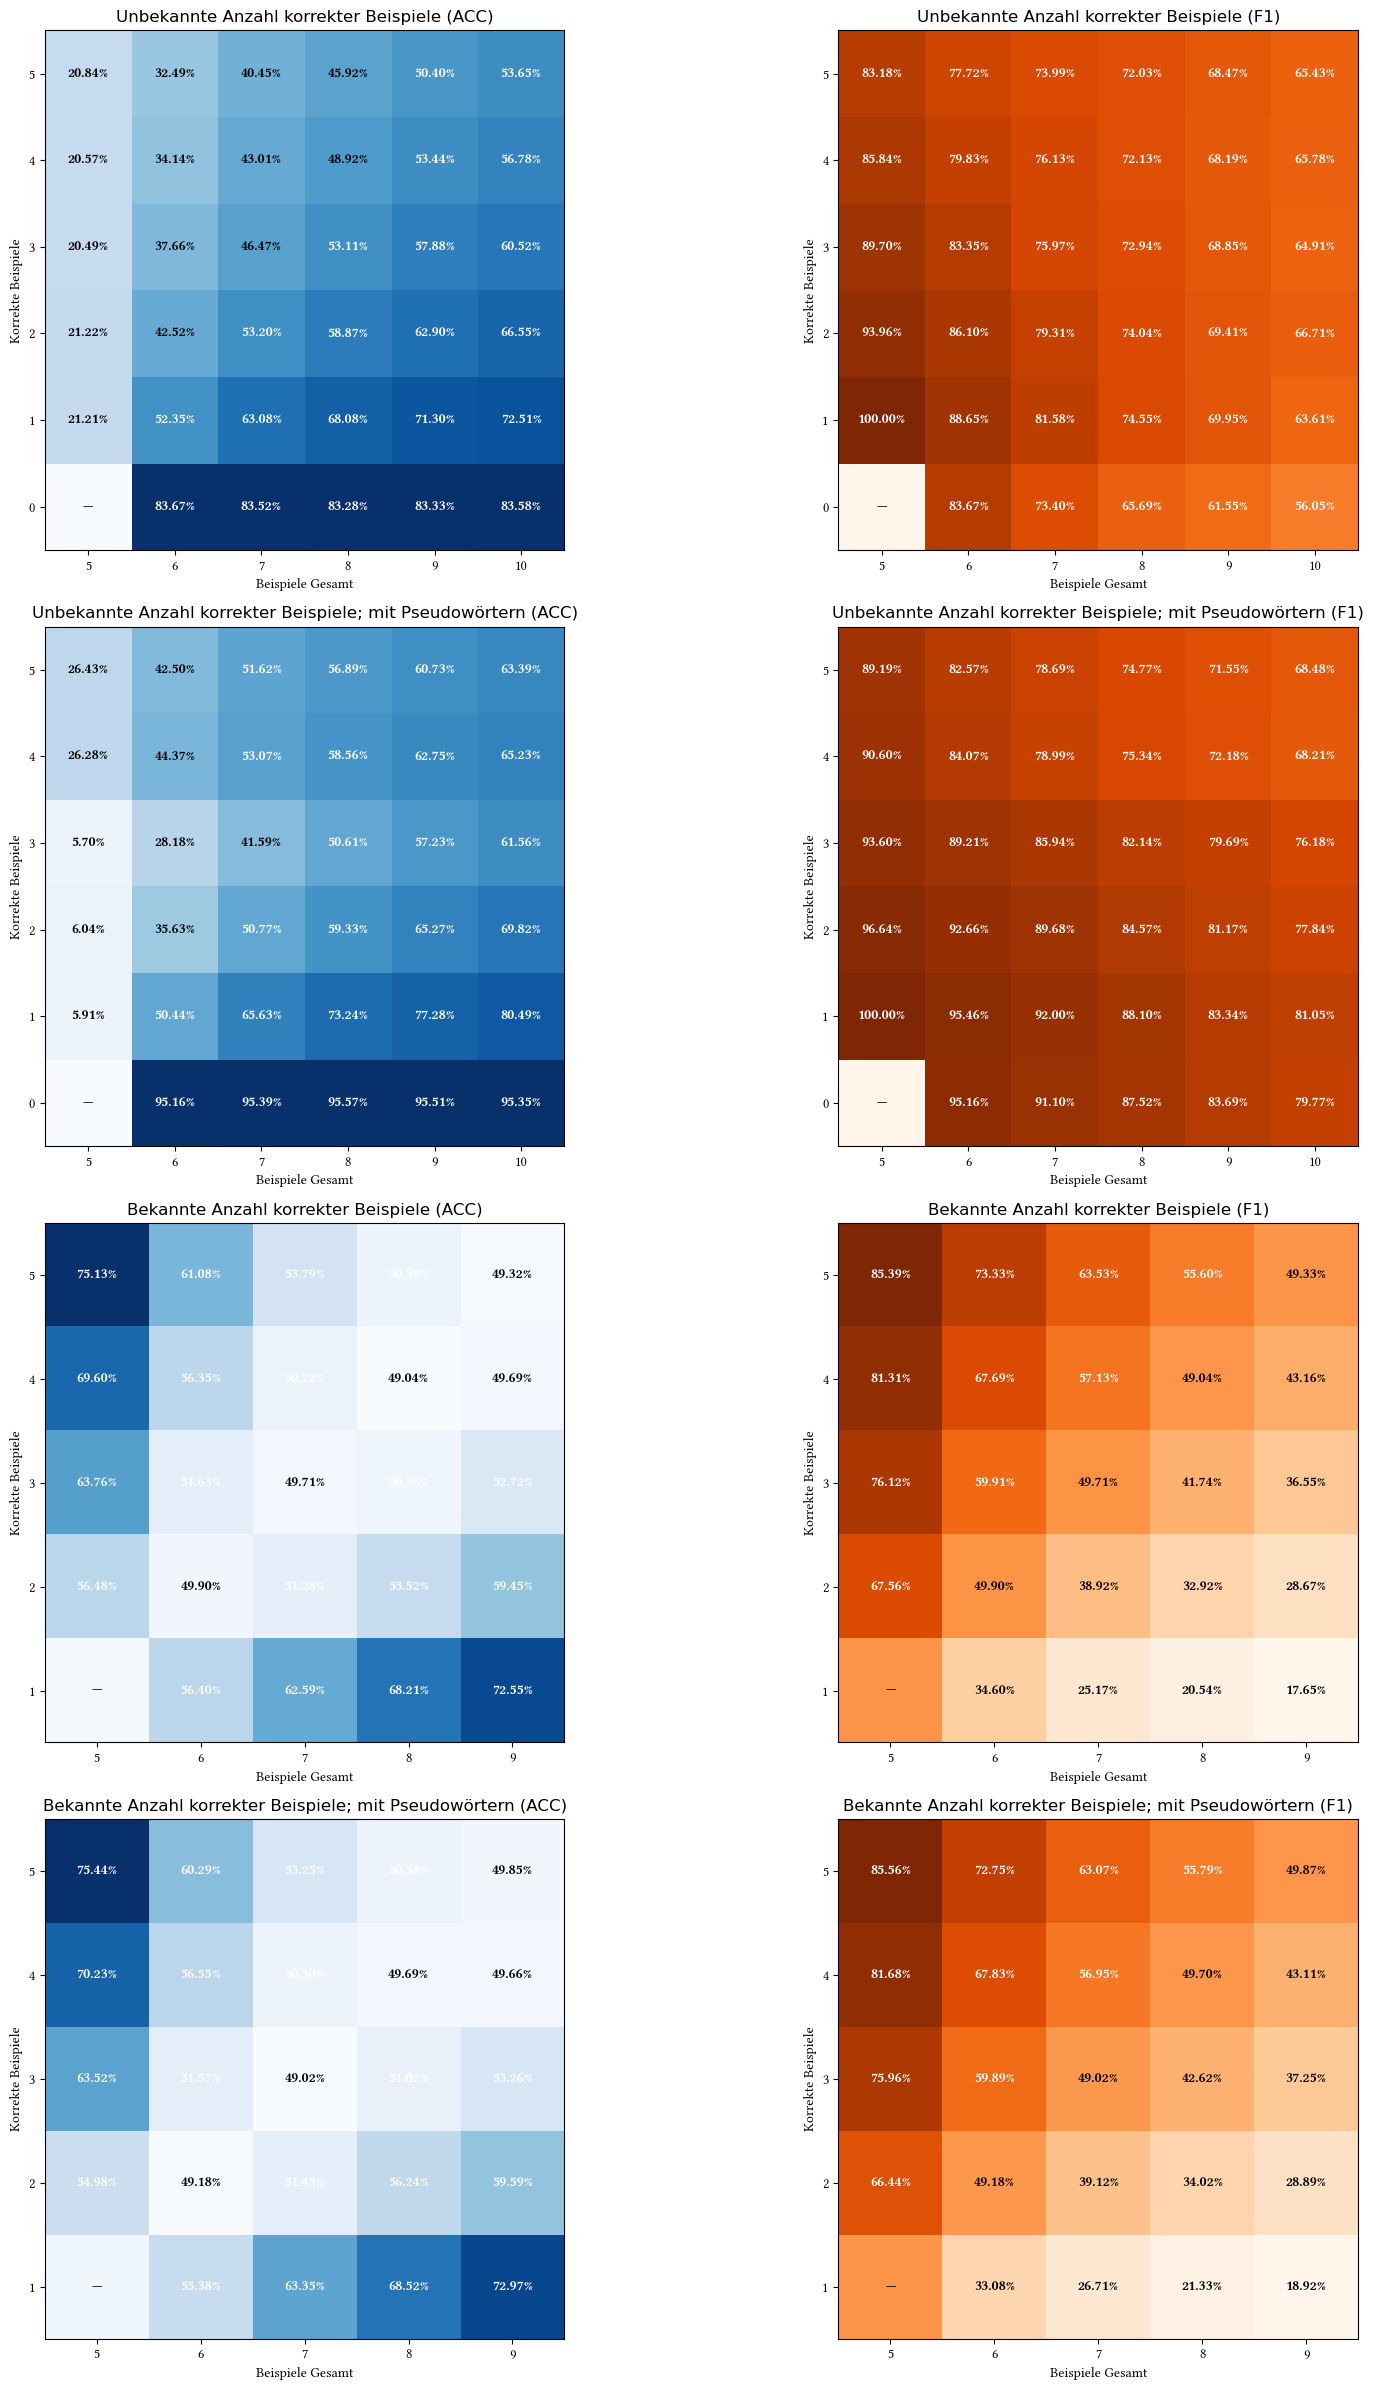

In [80]:
colors_accuracy = "Blues"
colors_f1 = "Oranges"
valuefont = {'fontname': 'Libertinus Serif', 'fontweight': 'heavy'}
captionfont = {'fontname': 'Libertinus Serif'}

metrics = [("accuracy", colors_accuracy), ("f1", colors_f1)]

fig, axs = plt.subplots(4, 2, figsize=(18, 24))

for i, suffix_1 in enumerate(suffixes_1):
    for j, suffix_2 in enumerate(suffixes_2):
        subset_dataframes = dataframes[(suffix_1, suffix_2)]
        for k, (metric, cmap) in enumerate(metrics):
            
            #matrix = np.zeros((len(subset_dataframes) + 1, len(subset_dataframes[(1, 1)][metric])))
            #for l, (num_true, num_false) in enumerate(sorted(subset_dataframes.keys())):
            #    matrix[l+1, :] = subset_dataframes[(num_true, num_false)][metric]
            #average_matrix = np.nanmean(matrix, axis=1)
            matrices = []
            # Loop through the subset_dataframes
            for num_true, num_false in tqdm(sorted(subset_dataframes.keys())):
                # Extract the metric values from each dataframe
                metric_values = subset_dataframes[(num_true, num_false)][metric].values
                # Append the metric values to the list
                matrices.append(metric_values)
            if (0, 1) in subset_dataframes.keys() or (1, 0) in subset_dataframes.keys():
                matrices = [np.zeros_like(matrices[0])] + matrices
            
            # Create an average matrix
            average_matrix = np.array([np.nanmean(matrix) for matrix in matrices])
            average_matrix = average_matrix.reshape((
                len(set(num_true for num_true, _ in subset_dataframes.keys())), 
                len(set(num_false for _, num_false in subset_dataframes.keys()))
            ))
            
            axs[i * 2 + j, k].imshow(average_matrix, cmap=cmap)
            axs[i * 2 + j, k].invert_yaxis()
            
            for m in range(average_matrix.shape[0]):
                for n in range(average_matrix.shape[1]):
                    if m == n == 0:
                        axs[i * 2 + j, k].text(0, 0, "—", ha='center', va='center', color='black', **valuefont)
                    else:
                        value = average_matrix[m, n]
                        axs[i * 2 + j, k].text(n, m, f"{value:.2%}", ha='center', va='center', color='black' if value < 0.5 else 'white', **valuefont)
            
            axs[i * 2 + j, k].set_xticks(range(average_matrix.shape[1]))
            axs[i * 2 + j, k].set_xticklabels(sorted(set(num_false for _, num_false in subset_dataframes.keys())), **captionfont)
            axs[i * 2 + j, k].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: str(x+average_matrix.shape[1])))

            axs[i * 2 + j, k].set_yticks(range(average_matrix.shape[0]))
            axs[i * 2 + j, k].set_yticklabels(sorted(set(num_true for num_true, _ in subset_dataframes.keys())), **captionfont)
            axs[i * 2 + j, k].set_xlabel("Beispiele Gesamt", **captionfont)  # Inkorrekte Beispiele + Korrekte Beispiele
            axs[i * 2 + j, k].set_ylabel("Korrekte Beispiele", **captionfont)
            match (suffix_1, suffix_2):
                case ("", "_kelex"):
                    axs[i * 2 + j, k].set_title(f"Unbekannte Anzahl korrekter Beispiele; mit Pseudowörtern ({metric.upper()[:3]})")
                case ("_2", "_kelex"):
                    axs[i * 2 + j, k].set_title(f"Bekannte Anzahl korrekter Beispiele; mit Pseudowörtern ({metric.upper()[:3]})")
                case ("_2", ""):
                    axs[i * 2 + j, k].set_title(f"Bekannte Anzahl korrekter Beispiele ({metric.upper()[:3]})")
                case _:
                    axs[i * 2 + j, k].set_title(f"Unbekannte Anzahl korrekter Beispiele ({metric.upper()[:3]})")

plt.tight_layout()
plt.show()